# WE11-Autoencoder

In [1]:
import numpy as np

## Load MNIST dataset

In [2]:
from tensorflow.keras.datasets import mnist


# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


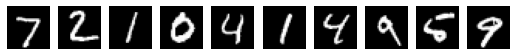

In [3]:
from matplotlib import pyplot as plt

n = 10
plt.figure(figsize=(9, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
  ax.axis('off')

plt.show()

## Load the supplied autoencoder

In [4]:
from tensorflow import keras

pretrained_model = keras.models.load_model('initially_trained_autoencoder.h5')

## Test the autoencoder model by reconstructing the test images and visually inspecting the results
## (Display the predictions for several random digits and compare these to the original. )

313/313 [==============================] - 1s 3ms/step


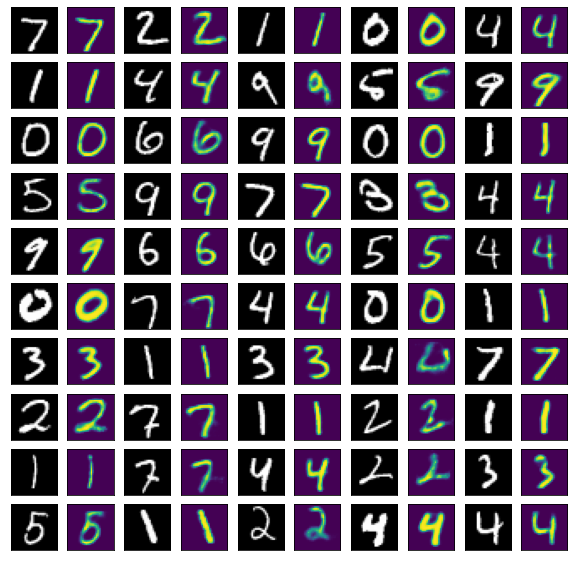

In [5]:
reconstructed_images = pretrained_model.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

## Load new images and test the autoencoder after loading new images

In [6]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [7]:
# load 5 sample images
images = []
for i in range(5):
    img = tf.keras.utils.load_img(f'a{i+1}.png', target_size=(28, 28), color_mode="grayscale")
    images.append(img)

In [8]:
# predict the images from the sample
input_arrs = []
for img in images:
    input_arr = tf.keras.utils.img_to_array(img)
    input_arr = input_arr/255  # normalize between 0 and 1
    input_arr = input_arr.reshape(784)
    input_arrs.append(input_arr)

input_arrs = np.array(input_arrs)  # Convert images to a batch of images

predictions = pretrained_model.predict(input_arrs)
print(predictions.shape)

1/1 [==============================] - 0s 24ms/step
(5, 784)


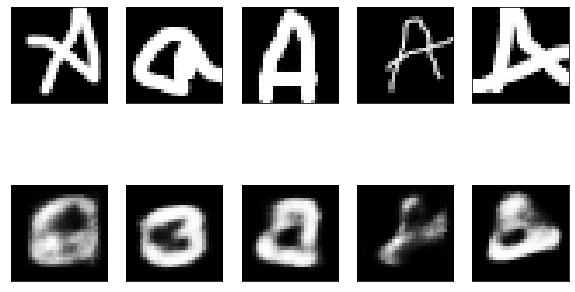

In [9]:
# display the images and their reconstructions side by side
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap="gray")
    
    plt.subplot(2, 5, i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predictions[i].reshape(28, 28), cmap="gray")

plt.show()

## OVERSAMPLING so that model can identify your new character

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Load and oversample images
images = []
for i in range(5):
    img = tf.keras.utils.load_img(f'a{i+1}.png', target_size=(28, 28), color_mode="grayscale")
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x.reshape((1,) + x.shape)  # Add batch dimension
    # Generate 500 augmented images for each original image
    for batch in datagen.flow(x, batch_size=1):
        images.append(batch[0].astype('uint8'))
        if len(images) % 500 == 0:  # Stop after 500 copies are created
            break

### Try to continue training the model on the original digits and with the new images mixed in   

Let's try to retrain the original model with a mix of the new images and the original. Our goal it so avoid retraining with the entire original test test, and instead only use a small subset of the original test set.

In [11]:
from tensorflow.keras.datasets import mnist


# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


In [12]:
# Create bad images and merge with training data
input_arrs = np.array(input_arrs)
bad_images = np.repeat(input_arrs, 27, axis=0)

new_image_set = np.vstack((train_images[:500], bad_images))
np.random.shuffle(new_image_set)

new_images_train = new_image_set[int(len(new_image_set)*.8):]
new_images_test = new_image_set[int(len(new_image_set)*.2):]

# NEW UPDATED AUTOENCODER MODEL

In [13]:
from tensorflow import keras
NEW_UPDATED_MODEL = keras.models.load_model('initially_trained_autoencoder.h5')

In [14]:
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training

# Train the autoencoder with MNIST data
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = NEW_UPDATED_MODEL.fit(
    x=new_images_train, # For autoencoders, both the input and the target are the same
    y=new_images_train, 
    epochs=15, 
    batch_size=128,
    shuffle=True, 
    validation_data=(new_images_test, new_images_test),
    callbacks=[early_stop]
)

Epoch 1/15
1/1 [==============================] - 1s 723ms/step - loss: 0.2294 - val_loss: 0.1843
Epoch 2/15
1/1 [==============================] - 0s 48ms/step - loss: 0.1971 - val_loss: 0.1608
Epoch 3/15
1/1 [==============================] - 0s 48ms/step - loss: 0.1704 - val_loss: 0.1578
Epoch 4/15
1/1 [==============================] - 0s 51ms/step - loss: 0.1670 - val_loss: 0.1586
Epoch 5/15
1/1 [==============================] - 0s 48ms/step - loss: 0.1664 - val_loss: 0.1552
Epoch 6/15
1/1 [==============================] - 0s 49ms/step - loss: 0.1602 - val_loss: 0.1530
Epoch 7/15
1/1 [==============================] - 0s 57ms/step - loss: 0.1562 - val_loss: 0.1459
Epoch 8/15
1/1 [==============================] - 0s 54ms/step - loss: 0.1475 - val_loss: 0.1396
Epoch 9/15
1/1 [==============================] - 0s 57ms/step - loss: 0.1398 - val_loss: 0.1354
Epoch 10/15
1/1 [==============================] - 0s 52ms/step - loss: 0.1336 - val_loss: 0.1294
Epoch 11/15
1/1 [===========

### Test the model on the original test set 
## Demonstrating  new encoding by showing the autencoder recreate a random set of digits

313/313 [==============================] - 1s 3ms/step


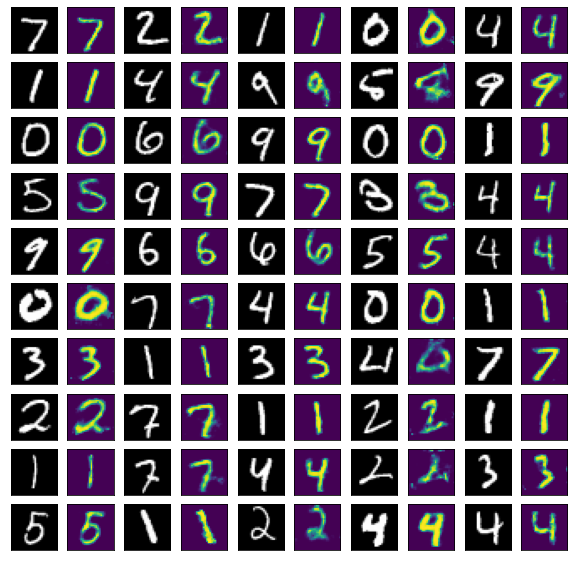

In [15]:
reconstructed_images = NEW_UPDATED_MODEL.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Test the model on the new test set 
## Demonstrating new encoding by showing the autencoder recreate new characters

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [17]:
# load 5 sample images
images = []
for i in range(5):
    img_path = f'a{i+1}.png'
    img = tf.keras.utils.load_img(img_path, target_size=(28, 28), color_mode = "grayscale")
    images.append(img)

In [18]:
# predict an image from this sample
input_arrs = []
for img in images:
    input_arr = tf.keras.utils.img_to_array(img)
    input_arr = input_arr/ 255 # normalize between 0 and 1
    input_arr = input_arr.reshape(784)
    input_arrs.append(input_arr)

input_arrs = np.array(input_arrs)
predictions = NEW_UPDATED_MODEL.predict(input_arrs)
print(predictions.shape)

1/1 [==============================] - 0s 23ms/step
(5, 784)


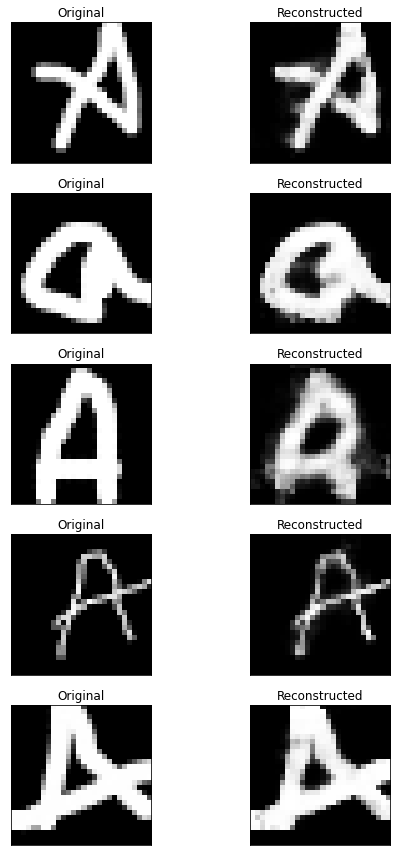

In [19]:
# display the two images side by side
rows = 5
cols = 2
fig, axs = plt.subplots(rows,cols,figsize=(8,12))

for i in range(rows):
    axs[i,0].imshow(images[i], cmap="gray")
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,0].set_title("Original")
    
    axs[i,1].imshow(predictions[i].reshape(28,28), cmap="gray")
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,1].set_title("Reconstructed")

plt.tight_layout()
plt.show()

### Save the autoencoder for later use.

In [20]:
NEW_UPDATED_MODEL.save('new_updated_autoencoder.h5')

# ANALYSIS 

When my new images are oversampled and added to the new updated model, they became the part of the training dataset and  the prediction of the original and reconstructed image by the model is more accurate(matching). 
The output Reconstructed images are matching with the original images which depicts that the model is identifying the new characters succesfully. 
If we want the model to remember the original and new characters then we should ensure that the problem of 'forgetting' the original digits, while 'remembering' new digits (catastrophic forgetting) does not arise.